# 遗传算法

本笔记本是 [AI for Beginners Curriculum](http://github.com/microsoft/ai-for-beginners) 的一部分。


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## 一些理论

**遗传算法** (GA) 基于一种**进化方法**的人工智能，其中利用种群进化的方法来获得给定问题的最优解。遗传算法由[约翰·亨利·霍兰德](https://en.wikipedia.org/wiki/John_Henry_Holland)于1975年提出。

遗传算法基于以下理念：
* 问题的有效解可以表示为**基因**
* **交叉**允许我们将两个解结合起来，生成新的有效解
* 使用某种**适应度函数**进行**选择**，以筛选出更优的解
* 引入**变异**以打破优化的稳定性，从而摆脱局部最优解

如果你想实现遗传算法，需要以下内容：

 * 找到一种方法，用**基因** $g\in\Gamma$ 来编码问题的解
 * 在基因集合 $\Gamma$ 上定义**适应度函数** $\mathrm{fit}: \Gamma\to\mathbb{R}$。函数值越小表示解越优。
 * 定义**交叉**机制，将两个基因结合起来生成新的有效解 $\mathrm{crossover}: \Gamma^2\to\Gamma$。
 * 定义**变异**机制 $\mathrm{mutate}: \Gamma\to\Gamma$。
在许多情况下，交叉和变异是相对简单的算法，用于将基因作为数值序列或位向量进行操作。

遗传算法的具体实现可能因情况而异，但总体结构如下：

1. 选择初始种群 $G\subset\Gamma$
2. 随机选择本步骤将执行的操作：交叉或变异
3. **交叉**：
  * 随机选择两个基因 $g_1, g_2 \in G$
  * 计算交叉结果 $g=\mathrm{crossover}(g_1,g_2)$
  * 如果 $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ 或 $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ - 用 $g$ 替换种群中的对应基因。
4. **变异** - 随机选择一个基因 $g\in G$ 并用 $\mathrm{mutate}(g)$ 替换它
5. 从步骤2开始重复，直到获得足够小的 $\mathrm{fit}$ 值，或者达到步骤数的限制。

遗传算法通常解决的任务：
1. 排程优化
1. 最优装箱
1. 最优切割
1. 加速穷举搜索


## 问题 1：公平分配宝藏

**任务**：  
两个人发现了一份宝藏，其中包含大小不同的钻石（因此价格也不同）。他们需要将宝藏分成两部分，使得两部分的价格差为0（或尽可能小）。

**正式定义**：  
我们有一个数字集合 $S$。需要将其分成两个子集 $S_1$ 和 $S_2$，使得  
$$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$  
并且满足 $S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$。

首先，我们来定义集合 $S$：


In [3]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[8344 2197 9335 3131 5863 9429 3818 9791   15 5455 1396 9538 4872 6549
 8587 5986 6021 9764 8102 5083 5739 7684 8498 3007 6599  820 7490 2372
 9370 5235 3525 3154  859 1906 8159 3950 2173 2988 2050  349 8713 2284
 4177 6033 1651 9176 5049 8201  171 5081 1216 3756 4711 2757 7738 1272
 5650 6584 5395 9004 7797  969 8104 1283 1392 4001 5768  445  274  256
 8239 8015 4381 9021 1189 8879 1411 3539 6526 8011  136 7230 2332  451
 5702 2989 4320 2446 9578 8486 4027 2410 9588 8981 2177 1493 3232 9151
 4835 5594 6859 8394  369 3200  126 4259 2283 7755 2014 2458 8327 8082
 7413 7622 1206 5533 8751 3495 5868 8472 6850 3958 3149 4672 4810 6274
 4700 6134 4627 4616 6656 9949  884 2256 7419 1926 7973 5319 5967 9158
 3823 7697 9466 5675 5412 9784 5426 8209 3421 1136 6047 4429 8001 4417
 1381  722 7350 6018 6235 7860 5853 7660 5937 6242    1 9552 3971 8302
 2633 9227 7283  154 8599 4269 9392 8539 1630  368 2409 9351 3838 9814
 6186 5743 5083 1325 1610  779 3643 3262 5768 8725  961 4611 6310 4788
 1648 

让我们通过一个二进制向量 $B\in\{0,1\}^N$ 对问题的每个可能解决方案进行编码，其中第 $i$ 个位置上的数字表示原始集合 $S$ 中的第 $i$ 个数字属于哪个集合（$S_1$ 或 $S_2$）。`generate` 函数将生成这些随机二进制向量。


In [5]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0]


现在我们定义`fit`函数来计算解决方案的“成本”。它将是两个集合$S_1$和$S_2$的总和之间的差值：


In [6]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

133784

现在我们需要定义变异和交叉的函数：
* 对于变异，我们将随机选择一个位并将其取反（从0变为1或从1变为0）
* 对于交叉，我们将从一个向量中取一些位，从另一个向量中取一些位。我们将使用相同的`generate`函数随机选择，从输入掩码中取哪些位。


In [7]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

让我们创建大小为`pop_size`的解的初始种群$P$：


In [8]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

现在，主要函数用于执行进化过程。`n` 是需要进行的进化步骤数。在每一步中：
* 以 30% 的概率进行变异，并用变异后的元素替换 `fit` 函数最差的元素
* 以 70% 的概率进行交叉

该函数返回最佳解决方案（对应于最佳解决方案的基因），以及每次迭代中种群中最小 `fit` 函数的历史记录。


In [9]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1] 4


你可以看到我们已经成功将 `fit` 函数大幅缩小了！下面是一个图表，展示了整个过程中整个种群的 `fit` 函数的变化情况。


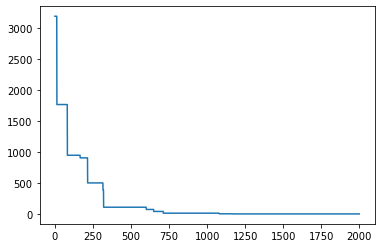

In [10]:
plt.plot(hist)
plt.show()

## 问题 2: N 皇后问题

**任务**:  
你需要在一个 $N\times N$ 的国际象棋棋盘上放置 $N$ 个皇后，使得它们互相之间不会攻击。

首先，我们不用遗传算法来解决这个问题，而是使用穷举法。我们可以用列表 $L$ 来表示棋盘的状态，其中列表的第 $i$ 个数字表示第 $i$ 行皇后所在的水平位置。显然，每种解法中每一行只会有一个皇后，并且每一行都会有一个皇后。

我们的目标是找到问题的第一个解，然后停止搜索。当然，你可以轻松扩展这个函数以生成所有可能的皇后位置。


In [11]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

现在让我们测量解决20皇后问题需要多长时间：


In [12]:
%timeit nqueens([],20,False)

10.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


现在让我们使用遗传算法来解决同样的问题。此解决方案的灵感来源于[这篇博客文章](https://kushalvyas.github.io/gen_8Q.html)。

我们将用长度为 $N$ 的相同列表来表示每个解决方案，并将攻击彼此的皇后数量作为 `fit` 函数：


In [13]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

由于计算适应度函数非常耗时，我们将每个解与适应度函数的值一起存储在种群中。让我们生成初始种群：


In [14]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([2, 3, 8, 7, 5, 4, 1, 6]), 4),
 (array([3, 4, 5, 1, 2, 8, 6, 7]), 8),
 (array([1, 3, 7, 4, 5, 8, 6, 2]), 6),
 (array([1, 5, 4, 6, 8, 3, 7, 2]), 4),
 (array([3, 5, 7, 1, 8, 6, 4, 2]), 3)]

现在我们需要定义变异和交叉函数。交叉将通过在某个随机点打断两个基因并将来自不同基因的两部分连接在一起来组合两个基因。


In [15]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 2, 7, 8])

In [17]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

现在我们来定义主要的进化循环。我们将稍微调整逻辑，与之前的例子有所不同，以展示可以如何灵活运用。我们会循环运行，直到找到完美的解决方案（适应度函数=0）。在每一步中，我们会处理当前的种群，并生成相同大小的新种群。这是通过 `nxgeneration` 函数完成的，具体步骤如下：

1. 丢弃最不适合的解决方案 - 有一个 `discard_unfit` 函数可以完成这项工作
1. 向种群中添加一些随机解决方案
1. 使用以下步骤为每个新基因生成大小为 `gen_size` 的新种群：
    - 随机选择两个基因，选择概率与适应度函数成正比
    - 计算交叉
    - 以概率 `mutation_prob` 应用变异


In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([4, 7, 5, 3, 1, 6, 8, 2]), 0)

在大多数情况下，我们能够很快找到解决方案，这很有趣，但在一些罕见的情况下，优化会达到局部最小值，过程会长时间停滞不前。在测量平均时间时，考虑到这一点非常重要：虽然在大多数情况下遗传算法比全面搜索更快，但在某些情况下可能会花费更长时间。为了解决这个问题，通常有必要限制考虑的代数数量，如果我们无法找到解决方案，可以从头开始。


In [19]:
%timeit genetic(10)

The slowest run took 18.71 times longer than the fastest. This could mean that an intermediate result is being cached.
26.4 s ± 28.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



---

**免责声明**：  
本文档使用AI翻译服务[Co-op Translator](https://github.com/Azure/co-op-translator)进行翻译。尽管我们努力确保翻译的准确性，但请注意，自动翻译可能包含错误或不准确之处。原始语言的文档应被视为权威来源。对于关键信息，建议使用专业人工翻译。我们不对因使用此翻译而产生的任何误解或误读承担责任。
